In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier , RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<h2>0. Dataset info</h2>
<strong>StudentID</strong>: A unique identifier assigned to each student (1001 to 3392).
Demographic Details
<hr>
<strong>Age</strong>: The age of the students ranges from 15 to 18 years.
<hr>
<strong>Gender</strong>: Gender of the students, where 0 represents Male and 1 represents Female.
<hr>
<strong>Ethnicity</strong>: The ethnicity of the students, coded as follows:

0: Caucasian

1: African American

2: Asian

3: Other
<hr>
<strong>ParentalEducation</strong>: The education level of the parents, coded as follows:

0: None

1: High School

2: Some College

3: Bachelor's

4: Higher
<hr>
<strong>StudyTimeWeekly</strong>: Weekly study time in hours, ranging from 0 to 20.
<hr>
<strong>Absences</strong>: Number of absences during the school year, ranging from 0 to 30.
<hr>
<strong>Tutoring</strong>: Tutoring status, where 0 indicates No and 1 indicates Yes.
Parental Involvement
<hr>
<strong>ParentalSupport</strong>: The level of parental support, coded as follows:

0: None

1: Low

2: Moderate

3: High

4: Very High
<hr>
<strong>Extracurricular</strong>: Participation in extracurricular activities, where 0 indicates No and 1 indicates Yes.
<hr>
<strong>Sports</strong>: Participation in sports, where 0 indicates No and 1 indicates Yes.
<hr>
<strong>Music</strong>: Participation in music activities, where 0 indicates No and 1 indicates Yes.
<hr>
<strong>Volunteering</strong>: Participation in volunteering, where 0 indicates No and 1 indicates Yes.
<hr>
<strong>GPA</strong>: Grade Point Average on a scale from 2.0 to 4.0, influenced by study habits, parental involvement, and extracurricular activities.
<hr>
<strong>GradeClass</strong>: Classification of students' grades based on GPA: (target)

0: 'A' (GPA >= 3.5)

1: 'B' (3.0 <= GPA < 3.5)

2: 'C' (2.5 <= GPA < 3.0)

3: 'D' (2.0 <= GPA < 2.5)

4: 'F' (GPA < 2.0)

In [307]:
csv_file_path = 'Student_performance_data _.csv'

try:
    df = pd.read_csv(csv_file_path)
    print("DataFrame created successfully:")
    display(df.head())
except ValueError as e:
    print("ValueError:", e)
except Exception as e:
    print("An error occurred:", e)

DataFrame created successfully:


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


Data is clean, without NaN, datatypes are already adjusted and our categorical columns are already correctly encoded. So we'll understand our dataset to have more knowledge about our problem

<h2>1. EDA</h2>

<h3>1.1. Correlation Study</h3>

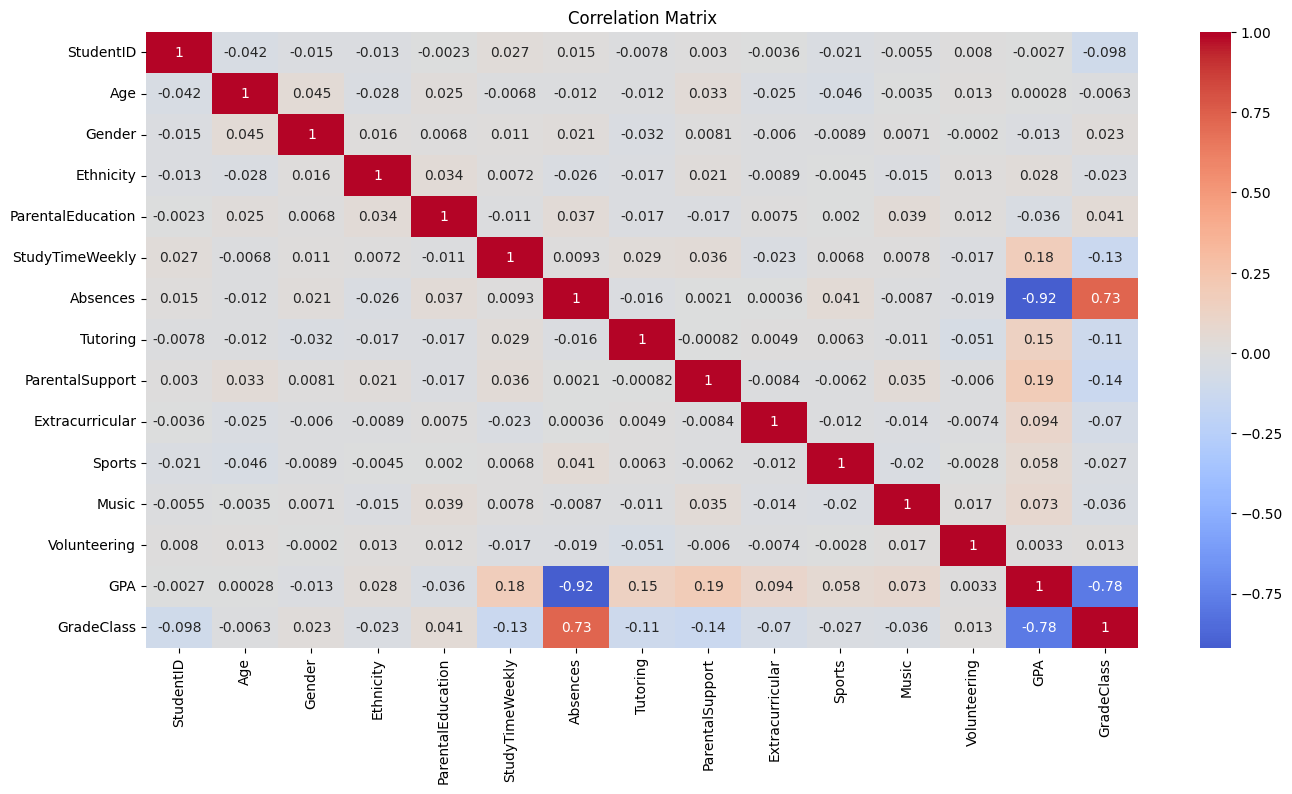

In [309]:
correlation_matrix = df.corr()

plt.figure(figsize=(16, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)


plt.title('Correlation Matrix')
plt.show()

From first glance we can detect a very big correlation using our target (GradeClass) with other features:
- The lower or GradeClass the better student in general. It have a very big correlation with Absences. The more absence lowers GradeClass gets bigger. This means absences affects strongly student performance
- GPA is a metric that means basically the same thing as GradeClass. We can work with Classifiers and target GradeClass or use Regression techniques and predic GPA. We'll test both!

In [310]:
df["GradeClass"].value_counts(normalize=True)

GradeClass
4.0    0.506271
3.0    0.173077
2.0    0.163462
1.0    0.112458
0.0    0.044732
Name: proportion, dtype: float64

We can notice that we are dealing with not so much balanced data. We have different and decrasing proportions between data.

<h3>1.2. Categorical Values</h3>

Lets Evaluate the distribuition of each of our categorical data:

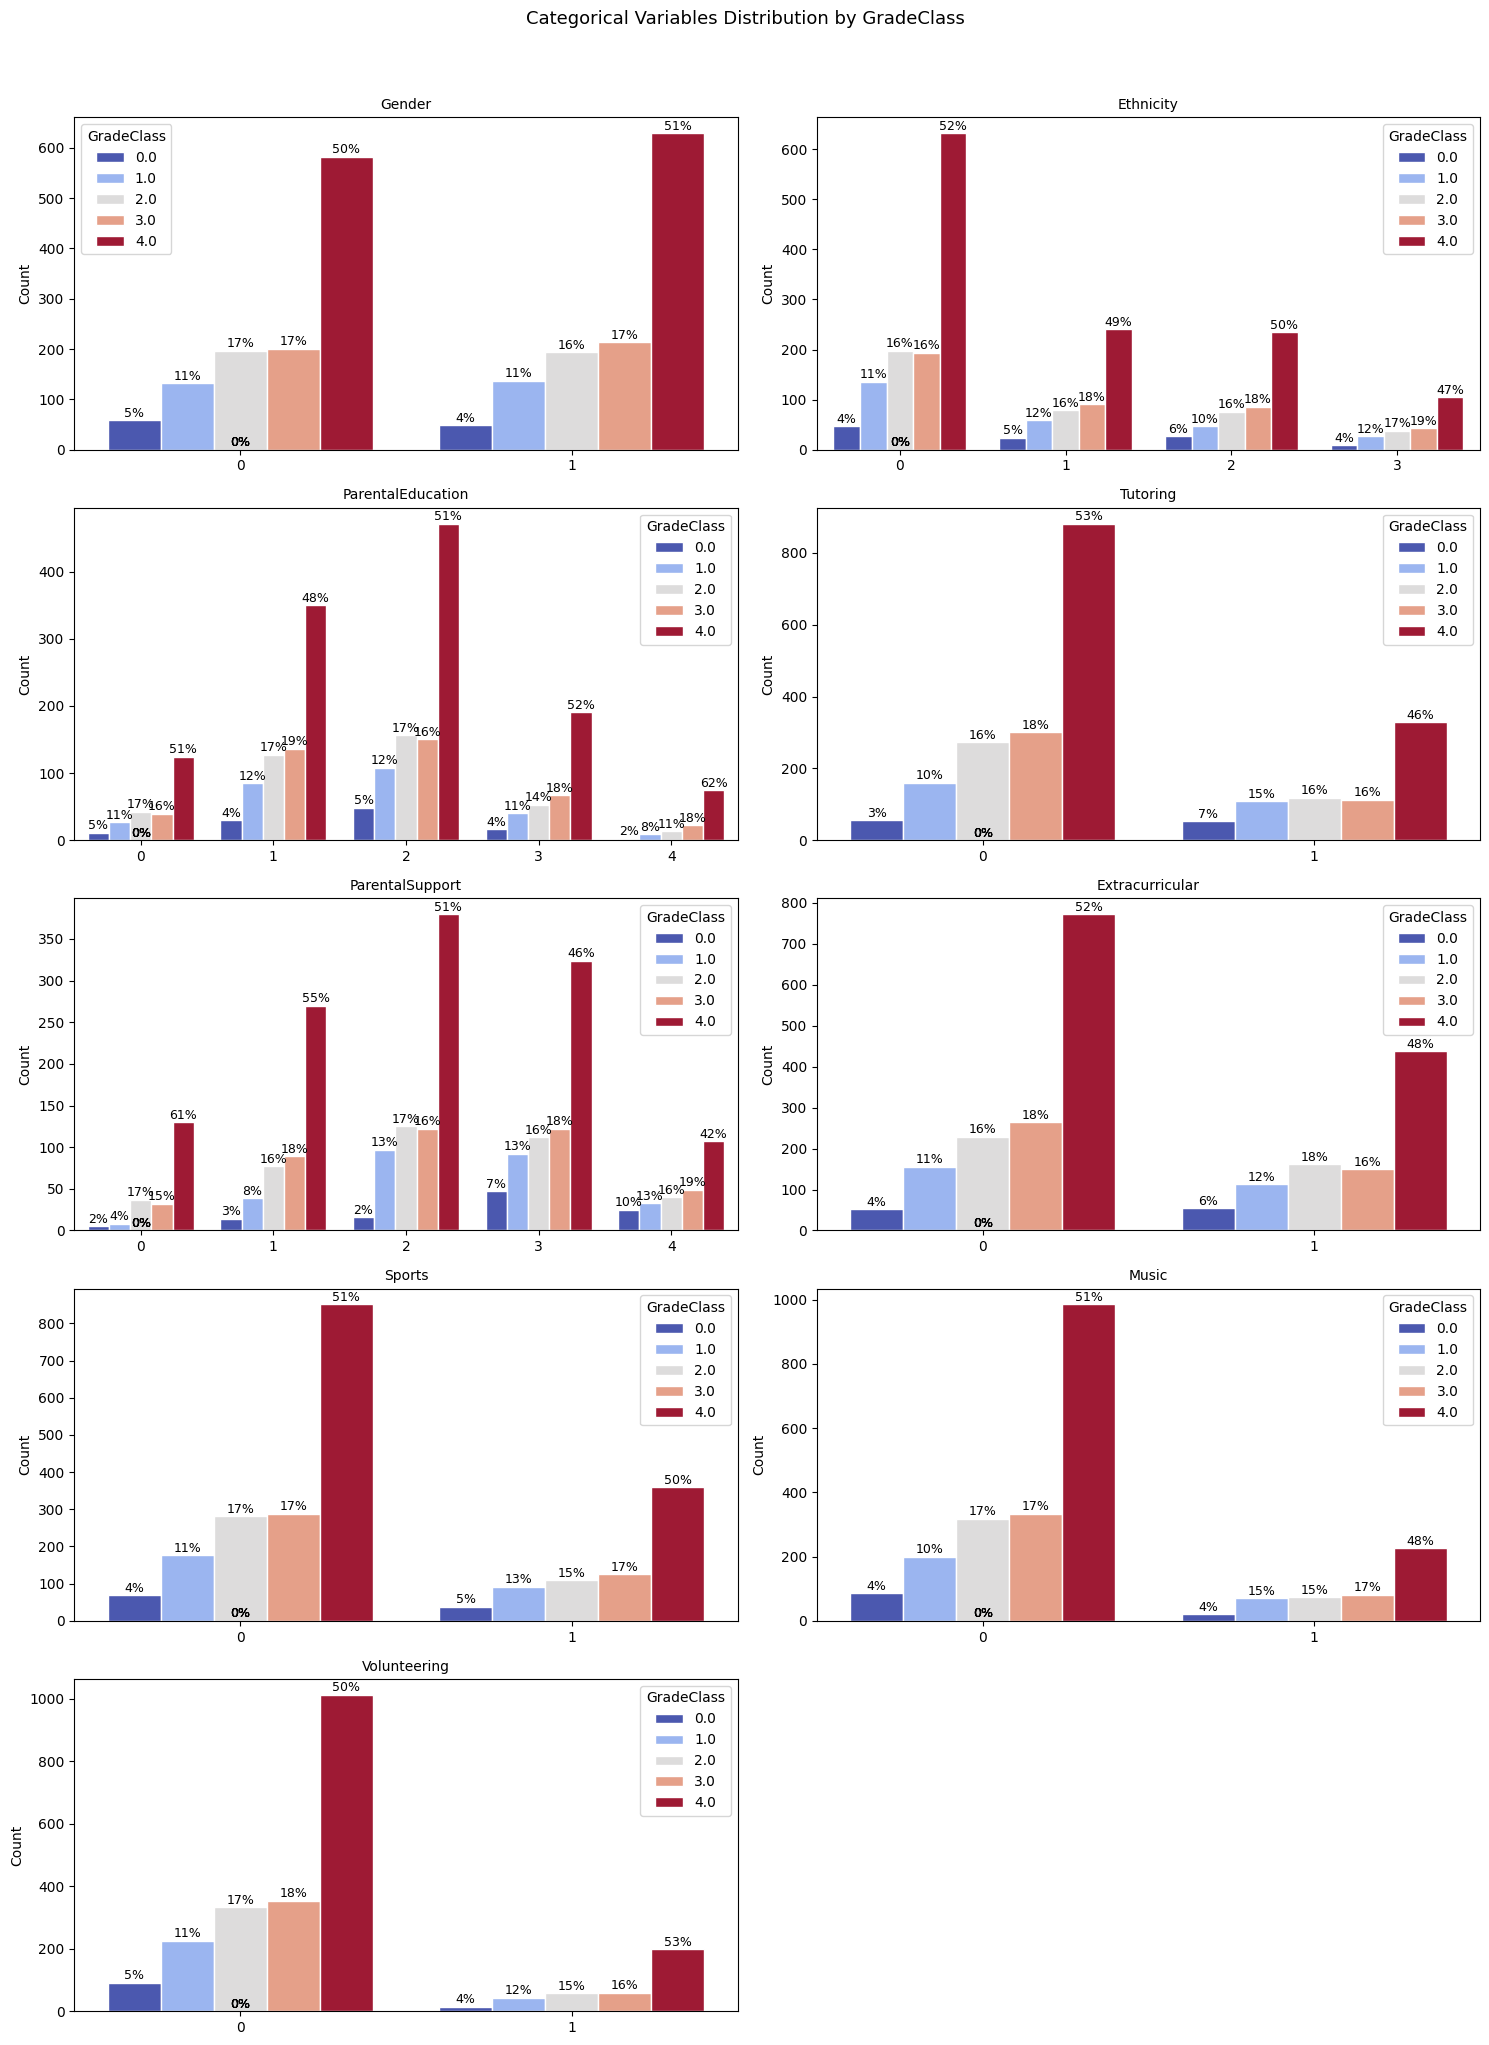

In [311]:
num_cols = ['StudyTimeWeekly', 'Absences']
cat_cols = ['Sports', 'Volunteering', 'ParentalSupport', 'Music', 'Extracurricular', 'ParentalEducation', 'Gender', 'Tutoring', 'Ethnicity']

fig, axs = plt.subplots(len(cat_col) // 2 + len(cat_col) % 2, 2, figsize=(15, 20))
axs = axs.flatten()

for i, col in enumerate(cat_col):
    sns.countplot(data=df, x=col, hue='GradeClass', ax=axs[i], palette='coolwarm', edgecolor='w')
    axs[i].set_title(col, fontsize=10)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Count')
    
    total_counts = df[col].value_counts()
    for p in axs[i].patches:
        height = p.get_height()
        category = p.get_x() + p.get_width() / 2
        category = round(category)
        total = total_counts[category]
        percentage = f'{height / total:.0%}'
        axs[i].annotate(percentage, (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Categorical Variables Distribution by GradeClass', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


The bar height indicates volumn and the percentage annotated represents the percentage of each GradeClass in that category value. Each Graph give us different intepretations:
<hr> 
<strong> First, lets remember our data distribuition in total values: </strong>
GradeClass

4 ->    50.62%

3 ->    17.30%

2 ->    16.34%

1 ->    11.24$

0 ->    4.47%
<hr>

So, there's some things we can notice qualitatively by our data:
<ol>
    <li>Students with more parental support are more likely to be above average and hits 'A' in GradeClass: looking at normalized values, we habe almost double the 'A' students for those who are supported</li>
    <li>The opposite of what is concluded above is true, less supported students tend to have less </li>
    <li>For some reason, students that have parents with higher degree are less likely to hit 'A'and more likely to hit 'F' in comparison to our standart</li>
</ol>

In [312]:
target_classification = df['GradeClass']
target_regression = df['GPA']

df_class = df[num_cols + cat_cols]
df_reg = df[num_cols]

In [313]:
df_class

,StudyTimeWeekly,Absences,Sports,Volunteering,ParentalSupport,Music,Extracurricular,ParentalEducation,Gender,Tutoring,Ethnicity
0,19.833723,7,0,0,2,1,0,2,1,1,0
1,15.408756,0,0,0,1,0,0,1,0,0,0
2,4.210570,26,0,0,2,0,0,3,0,0,2
3,10.028829,14,0,0,3,0,1,3,1,0,0
4,4.672495,17,0,0,3,0,0,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2387,10.680555,2,0,0,4,0,1,3,1,0,0
2388,7.583217,4,1,0,4,0,0,1,0,1,0
2389,6.805500,20,0,1,2,0,0,2,1,0,0
2390,12.416653,17,1,0,2,1,0,0,1,0,1


In [314]:
df_reg

,StudyTimeWeekly,Absences
0,19.833723,7
1,15.408756,0
2,4.210570,26
3,10.028829,14
4,4.672495,17
...,...,...
2387,10.680555,2
2388,7.583217,4
2389,6.805500,20
2390,12.416653,17


<h2>2. Classification Models</h2>

Normalizing data:

In [315]:
df_class[num_cols] = (df_class[num_cols] - df_class[num_cols].mean())/df_class[num_cols].std()
df_class

/var/folders/mx/1c1hr6096hd7bz7xt9yf1b340000gn/T/ipykernel_4295/1113021449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_class[num_cols] = (df_class[num_cols] - df_class[num_cols].mean())/df_class[num_cols].std()


,StudyTimeWeekly,Absences,Sports,Volunteering,ParentalSupport,Music,Extracurricular,ParentalEducation,Gender,Tutoring,Ethnicity
0,1.779963,-0.890636,0,0,2,1,0,2,1,1,0
1,0.997168,-1.717334,0,0,1,0,0,1,0,0,0
2,-0.983839,1.353259,0,0,2,0,0,3,0,0,2
3,0.045436,-0.063938,0,0,3,0,1,3,1,0,0
4,-0.902123,0.290362,0,0,3,0,0,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2387,0.160729,-1.481135,0,0,4,0,1,3,1,0,0
2388,-0.387204,-1.244935,1,0,4,0,0,1,0,1,0
2389,-0.524785,0.644661,0,1,2,0,0,2,1,0,0
2390,0.467852,0.290362,1,0,2,1,0,0,1,0,1


In [316]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVC': SVC(),
    'Bagging': BaggingClassifier(),
    'XGB': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

X_train, X_test, y_train, y_test = train_test_split(df_class, target_classification, test_size=0.2, random_state=42)

Evaluating Decision Tree:
Decision Tree: Accuracy = 0.6409
Classification Report:
              precision    recall  f1-score   support

         0.0       0.40      0.18      0.25        22
         1.0       0.35      0.47      0.40        49
         2.0       0.47      0.33      0.39        85
         3.0       0.41      0.42      0.42        86
         4.0       0.84      0.91      0.87       237

    accuracy                           0.64       479
   macro avg       0.50      0.46      0.47       479
weighted avg       0.63      0.64      0.63       479



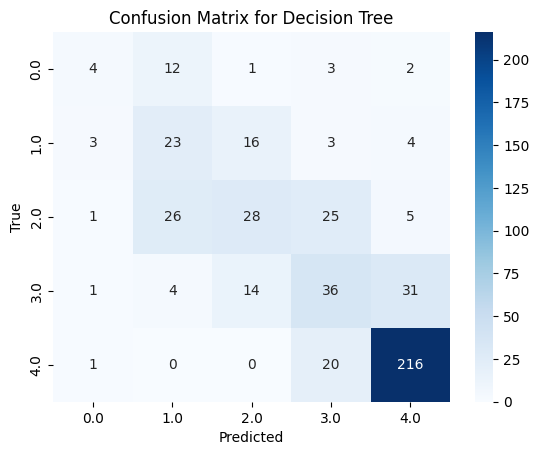

Evaluating Random Forest:
Random Forest: Accuracy = 0.6973
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.09      0.16        22
         1.0       0.51      0.53      0.52        49
         2.0       0.53      0.56      0.55        85
         3.0       0.49      0.42      0.45        86
         4.0       0.85      0.94      0.89       237

    accuracy                           0.70       479
   macro avg       0.61      0.51      0.51       479
weighted avg       0.69      0.70      0.68       479



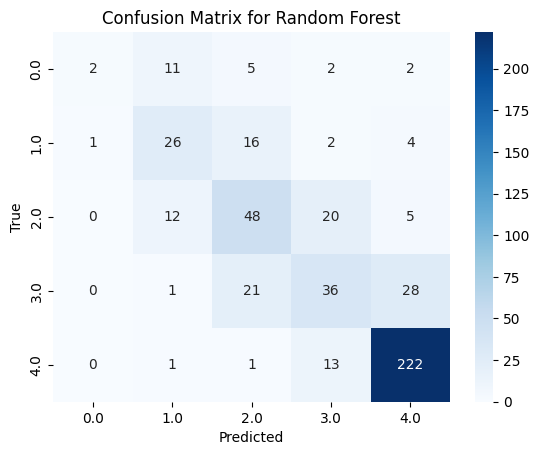

Evaluating Gradient Boosting:
Gradient Boosting: Accuracy = 0.6868
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.23      0.33        22
         1.0       0.44      0.49      0.47        49
         2.0       0.48      0.51      0.49        85
         3.0       0.51      0.43      0.47        86
         4.0       0.86      0.93      0.89       237

    accuracy                           0.69       479
   macro avg       0.59      0.52      0.53       479
weighted avg       0.68      0.69      0.68       479



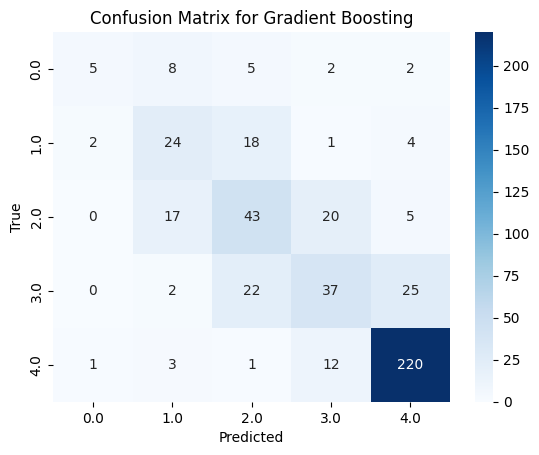

Evaluating SVC:
SVC: Accuracy = 0.7015
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.23      0.36        22
         1.0       0.48      0.57      0.52        49
         2.0       0.55      0.52      0.53        85
         3.0       0.50      0.48      0.49        86
         4.0       0.86      0.92      0.89       237

    accuracy                           0.70       479
   macro avg       0.65      0.54      0.56       479
weighted avg       0.70      0.70      0.69       479



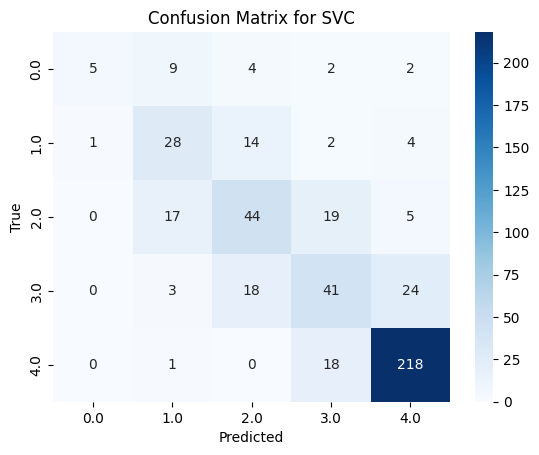

Evaluating Bagging:
Bagging: Accuracy = 0.7140
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.27      0.41        22
         1.0       0.55      0.57      0.56        49
         2.0       0.54      0.55      0.55        85
         3.0       0.52      0.48      0.50        86
         4.0       0.86      0.93      0.89       237

    accuracy                           0.71       479
   macro avg       0.67      0.56      0.58       479
weighted avg       0.71      0.71      0.70       479



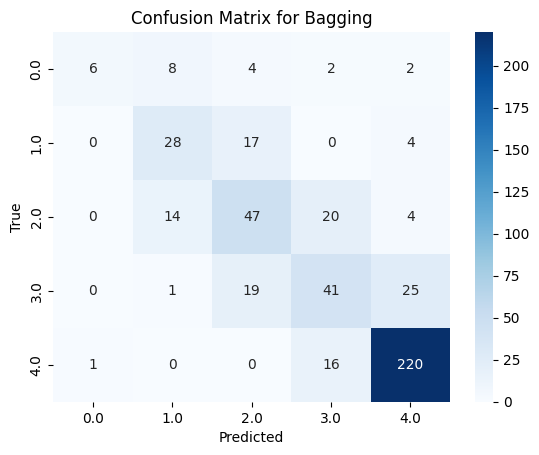

Evaluating XGB:
XGB: Accuracy = 0.7244
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.23      0.37        22
         1.0       0.50      0.59      0.54        49
         2.0       0.56      0.54      0.55        85
         3.0       0.56      0.51      0.54        86
         4.0       0.87      0.94      0.90       237

    accuracy                           0.72       479
   macro avg       0.70      0.56      0.58       479
weighted avg       0.73      0.72      0.71       479



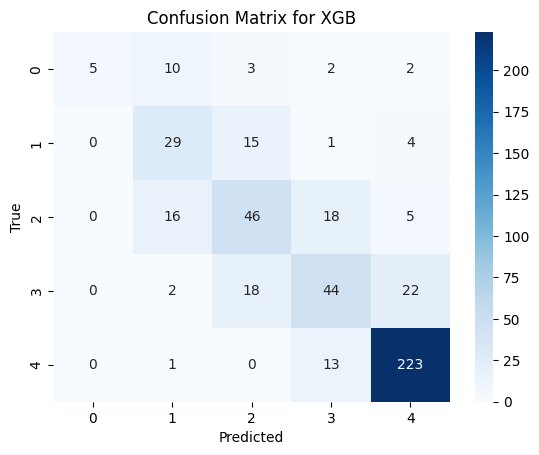

Evaluating AdaBoost:
AdaBoost: Accuracy = 0.6576
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        22
         1.0       0.40      0.39      0.40        49
         2.0       0.47      0.55      0.51        85
         3.0       0.43      0.42      0.43        86
         4.0       0.85      0.90      0.87       237

    accuracy                           0.66       479
   macro avg       0.43      0.45      0.44       479
weighted avg       0.63      0.66      0.64       479



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

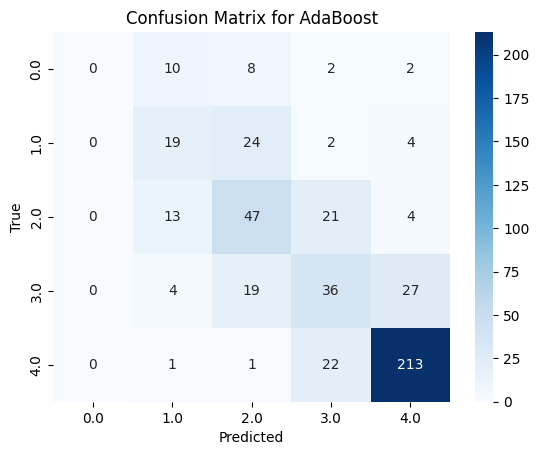

In [317]:
param_grids = {
    'Decision Tree': {'max_depth': [3, 5, 20], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 20], 'min_samples_split': [2, 5, 10]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'SVC': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    'Bagging': {'n_estimators': [10, 50, 100], 'max_samples': [0.5, 1.0], 'max_features': [0.5, 1.0]},
    'XGB': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
}

best_accuracy = 0.0
best_model_name = None
final_model = None

for model_name, model in models.items():
    print(f"Evaluating {model_name}:")
    
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name}: Accuracy = {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
        final_model = best_model


<h4>Results</h4>

In [318]:
print(f"The best model ({best_model_name}) with accuracy: {best_accuracy:.4f}\n\n")

grid_search_params = {
    'n_estimators' : final_model.n_estimators,
    'learning_rate': final_model.learning_rate,
    'max_depth': final_model.max_depth,
}
#'XGB': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},

grid_search_params_json = json.dumps(grid_search_params, indent=4)
print(grid_search_params_json)


The best model (XGB) with accuracy: 0.7244


{
    "n_estimators": 50,
    "learning_rate": 0.1,
    "max_depth": 5
}


<h2>3. Regressors</h2>

In [319]:
models_reg = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVC': SVR(),
    'Bagging': BaggingRegressor(),
    'XGB': XGBRegressor(),
    'AdaBoost': AdaBoostRegressor()
}

X_train, X_test, y_train, y_test = train_test_split(df_reg, target_regression, test_size=0.2, random_state=42)

In [320]:
param_grids_reg = {
    'Linear Regression': {},
    'Decision Tree': {'max_depth': [3, 5, 20], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 20], 'min_samples_split': [2, 5, 10]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'SVC': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    'Bagging': {'n_estimators': [10, 50, 100], 'max_samples': [0.5, 1.0], 'max_features': [0.5, 1.0]},
    'XGB': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
}

best_r2_score = -float('inf')
best_model_name = None

for model_name, model in models_reg.items():
    print(f"Evaluating {model_name}:")
    
    param_grid = param_grids_reg[model_name]
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='r2')
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name}: R2 Score = {r2:.4f}")
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print(best_model.score(X_test, y_test))
    print("\n")
    
    # Additional evaluation metrics and visualizations can be added here if needed
    
    if r2 > best_r2_score:
        best_r2_score = r2
        best_model_name = model_name
        final_model_reg = best_model

Evaluating Linear Regression:
Linear Regression: R2 Score = 0.8776
Mean Squared Error: 0.10122843824972941
0.8775856260448773


Evaluating Decision Tree:
Decision Tree: R2 Score = 0.8564
Mean Squared Error: 0.11878594829951776
0.8563535331852272


Evaluating Random Forest:
Random Forest: R2 Score = 0.8693
Mean Squared Error: 0.10810188384929724
0.8692736481606592


Evaluating Gradient Boosting:
Gradient Boosting: R2 Score = 0.8717
Mean Squared Error: 0.10607242378935937
0.8717278506258928


Evaluating SVC:
SVC: R2 Score = 0.8762
Mean Squared Error: 0.10237362737953051
0.8762007621389563


Evaluating Bagging:
Bagging: R2 Score = 0.8607
Mean Squared Error: 0.11519993604353898
0.8606900561317542


Evaluating XGB:
XGB: R2 Score = 0.8716
Mean Squared Error: 0.10621259447649357
0.8715583438429266


Evaluating AdaBoost:
AdaBoost: R2 Score = 0.8611
Mean Squared Error: 0.11485939570465656
0.8611018676059954




In [321]:
print(f"The best model ({best_model_name}) with Rˆ2: {best_r2_score:.4f}\n\n")

The best model (Linear Regression) with Rˆ2: 0.8776




<h2>4. Conclusions</h2>

So we tested two different types of models:

Classifications, which XGB performed the best with accuracy of 72.44%, and what does it mean?

If we just guessed the greatest value ('F') we could have gone right about 50% of cases. The model gave us a slightly higher accuracy so it is definetly better than a gess and way better then just saying "F" for every student you go across.

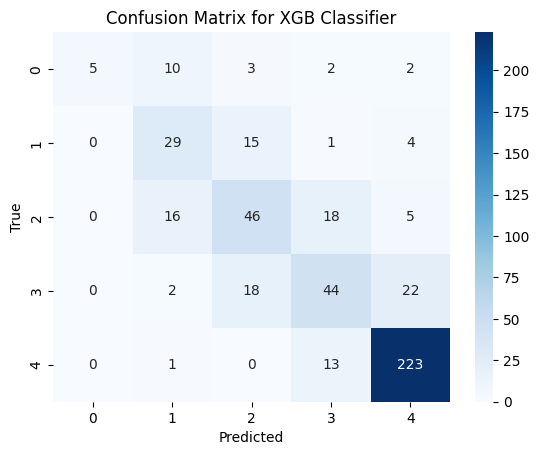

In [322]:
X_train, X_test, y_train, y_test = train_test_split(df_class, target_classification, test_size=0.2, random_state=42)
y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=final_model.classes_, yticklabels=final_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for XGB Classifier')
plt.show()

ands when we see its confusion matrix we can notice that extreme mistakes are very rare, so confusion matrix main diagonal is more populated then its extremes, wich is a satisfatory result, but it can be further improved.

But we saw that GPA and GradeClass are the same evaluation metric and in our all columns correlation matrix we saw that we have columns with very high correlation with GPA, so we tested regression techniques using only our numerical values and we got the incredible 0.8776 fitting. So Regression can be a good alternative in the case!

Thank y'all for seeing and please, if you note that i made some theoretical or practical mistake, comment or tell me! im a always growing being and love to learn, debate and knowledge, lets talk!